## 1.Load the data, Women's Clothing E-Commerce Reviews.csv Download Women's Clothing E-Commerce Reviews.csv, into memory.

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

df = pd.read_csv('/content/Womens Clothing E-Commerce Reviews.csv',sep = ',')

## 2.Please concatenate the Title, Review Text, Division Name, Department Name, and Class Name as a new feature of Reviews.

In [ ]:
df['Review']= df['Title'].fillna('') + ' ' +\
            df['Review Text'].fillna('') + ' ' +\
            df['Division Name'].fillna('') + ' ' +\
            df['Department Name'].fillna('') + ' ' +\
            df['Class Name'].fillna('')


In [ ]:
df.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Review
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,Absolutely wonderful - silky and sexy and com...
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,Love this dress! it's sooo pretty. i happen...
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,Some major design flaws I had such high hopes ...
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants,"My favorite buy! I love, love, love this jumps..."
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses,Flattering shirt This shirt is very flattering...


## 3.Please clean the new feature of Reviews using regular expressions.

In [ ]:
# Remove all special characters, punctuation and spaces
df['Review'] = df['Review'].apply(lambda x: re.sub(r'[^A-Za-z0-9]+',' ',x))
# Replace special characters,<br />,  in the file
#df['Review'] = df['Review'].apply(lambda x: re.sub(r"<br />", " ", x))
# Remove length <=2
df['Review'] = df['Review'].apply(lambda x: re.sub(r'\b[a-zA-Z]{1,2}\b', '', x))

## 4.Build an RNN model to forecast the Recommended IND based on Reviews using TensorFlow.

In [ ]:
X = df['Review'].values
y = df['Recommended IND'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify= y, test_size=0.2)
#X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, stratify=y_train, test_size=0.5)
print(f'X_train size  ={X_train.shape}; X_test size  ={X_test.shape}')

X_train size  =(18788,); X_test size  =(4698,)


In [ ]:
# Specify the vocab size
VOCAB_SIZE = 1000
# Perform textvectorization
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)

# Fits the state of the preprocessing layer to the dataset.
encoder.adapt(X_train)

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'this', 'general', 'but', 'for',
       'dresses', 'with', 'dress', 'was', 'tops', 'not', 'love', 'petite',
       'that', 'size', 'very', 'top'], dtype='<U13')

In [ ]:
model = tf.keras.Sequential([
    # Convert review text to indices
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    #
    tf.keras.layers.GRU(128, return_sequences=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
    # Binary classifier
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## 5.Evaluate the model and check the model fit. Do you recommend this model? Please justify your answer.

In [ ]:
%%time
history = model.fit(x=X_train,y=y_train,batch_size= 32,epochs=5,
          validation_data=(X_test,y_test), verbose= 1
          )

Epoch 1/5
588/588 [==============================] - 209s 339ms/step - loss: 0.3503 - accuracy: 0.7997 - val_loss: 0.2465 - val_accuracy: 0.8966
Epoch 2/5
588/588 [==============================] - 191s 324ms/step - loss: 0.2124 - accuracy: 0.9054 - val_loss: 0.2210 - val_accuracy: 0.9068
Epoch 3/5
588/588 [==============================] - 202s 344ms/step - loss: 0.1963 - accuracy: 0.9150 - val_loss: 0.2223 - val_accuracy: 0.9110
Epoch 4/5
588/588 [==============================] - 200s 341ms/step - loss: 0.1898 - accuracy: 0.9171 - val_loss: 0.2230 - val_accuracy: 0.9127
Epoch 5/5
588/588 [==============================] - 189s 322ms/step - loss: 0.1859 - accuracy: 0.9208 - val_loss: 0.2192 - val_accuracy: 0.9019
CPU times: user 25min 42s, sys: 1min 19s, total: 27min 1s
Wall time: 17min 31s


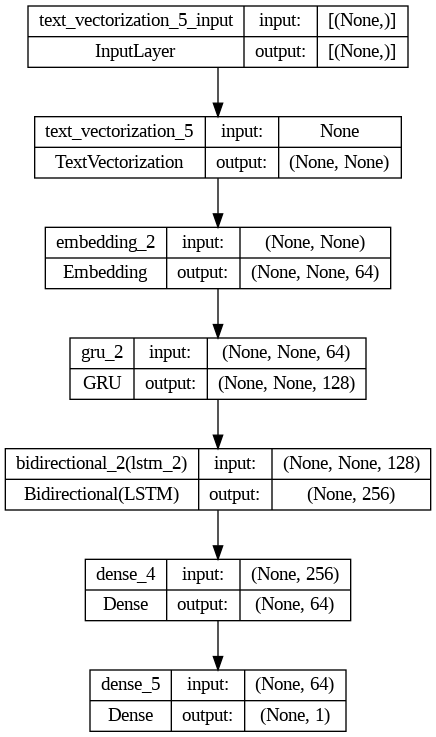

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

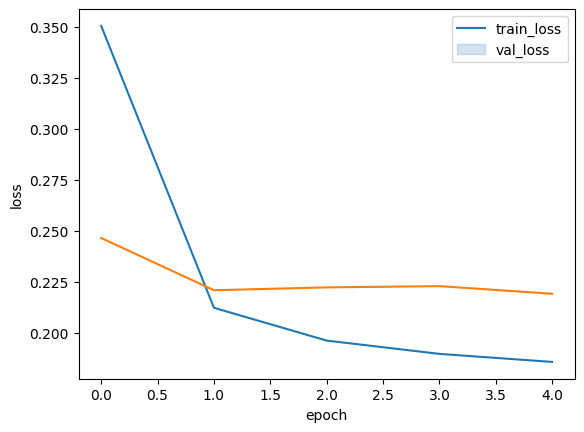

In [ ]:
train_history = pd.DataFrame(history.history)
train_history['epoch'] = history.epoch
# Plot train loss
sns.lineplot(x='epoch', y ='loss', data =train_history)
# Plot validation loss
sns.lineplot(x='epoch', y ='val_loss', data =train_history)
# Add legends
plt.legend(labels=['train_loss', 'val_loss'])

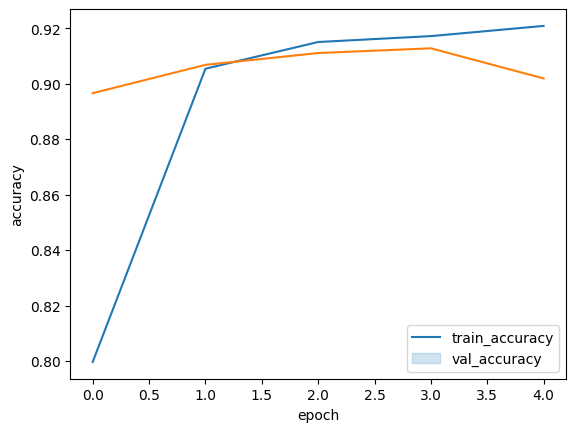

In [ ]:
sns.lineplot(x='epoch', y ='accuracy', data =train_history)
# Plot validation loss
sns.lineplot(x='epoch', y ='val_accuracy', data =train_history)
# Add legends
plt.legend(labels=['train_accuracy', 'val_accuracy'])

In [ ]:
# the cutoff probability is 50%
y_pred = (model.predict(X_test)> 0.5).astype(int)

147/147 [==============================] - 17s 88ms/step


In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[ 678,  157],
       [ 304, 3559]])

In [ ]:
from sklearn.metrics import classification_report
label_names = ['negative', 'positive']
print(classification_report(y_test, y_pred, target_names=label_names))

              precision    recall  f1-score   support

    negative       0.69      0.81      0.75       835
    positive       0.96      0.92      0.94      3863

    accuracy                           0.90      4698
   macro avg       0.82      0.87      0.84      4698
weighted avg       0.91      0.90      0.90      4698

